In [1]:
import pandas as pd
import numpy as np
import model
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
sqlForTraining = """
select
	eta.idetablissement,
	eta.departement,
	eta.siren,
	eta.geores_lat,
	eta.geores_lon,
	eta.nb_agrements,
	eta.nb_inspections,
	CAST (eta.moy_score*10 AS INTEGER) as moy_score,
	eta.commune_norm,
	act.idactivite,
	act.categorie_frais,
	CASE 
      WHEN ins.synthese_eval = 'Très satisfaisant'  THEN 4
      WHEN ins.synthese_eval = 'Satisfaisant'  THEN 3
      WHEN ins.synthese_eval = 'A améliorer'  THEN 2
      WHEN ins.synthese_eval = 'A corriger de manière urgente'  THEN 1
	END	as synthese_eval
from inspection ins
join etablissement eta on ins.idetablissement = eta.idetablissement
join activite act on ins.idactivite = act.idactivite
order by eta.idetablissement
"""



In [3]:
df = pd.read_sql_query(sqlForTraining, model.session.connection())

df['moy_score'].astype('int')

df = df.sample(frac=1).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35586 entries, 0 to 35585
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idetablissement  35586 non-null  int64  
 1   departement      35586 non-null  int64  
 2   siren            35586 non-null  object 
 3   geores_lat       35586 non-null  float64
 4   geores_lon       35586 non-null  float64
 5   nb_agrements     35586 non-null  int64  
 6   nb_inspections   35586 non-null  int64  
 7   moy_score        35586 non-null  int64  
 8   commune_norm     35586 non-null  object 
 9   idactivite       35586 non-null  int64  
 10  categorie_frais  35586 non-null  bool   
 11  synthese_eval    35586 non-null  int64  
dtypes: bool(1), float64(2), int64(7), object(2)
memory usage: 3.0+ MB


In [4]:
X = df[[ 'commune_norm', 'geores_lat', 'geores_lon', 'siren', 'categorie_frais', 'nb_agrements', 'nb_inspections', 'departement', 'idactivite']]
X['categorie_frais'] = X['categorie_frais'].astype('int')

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
X['siren'] = labelencoder.fit_transform(X['siren'])
X['commune_norm'] = labelencoder.fit_transform(X['commune_norm'])

y = df['synthese_eval']

C:\Users\jean\AppData\Local\Temp\ipykernel_15220\3709682832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categorie_frais'] = X['categorie_frais'].astype('int')
C:\Users\jean\AppData\Local\Temp\ipykernel_15220\3709682832.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['siren'] = labelencoder.fit_transform(X['siren'])
C:\Users\jean\AppData\Local\Temp\ipykernel_15220\3709682832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [5]:
print(np.unique(y, return_counts=True))

(array([1, 2, 3, 4], dtype=int64), array([  114,  1661, 18812, 14999], dtype=int64))


In [6]:
# X.info()

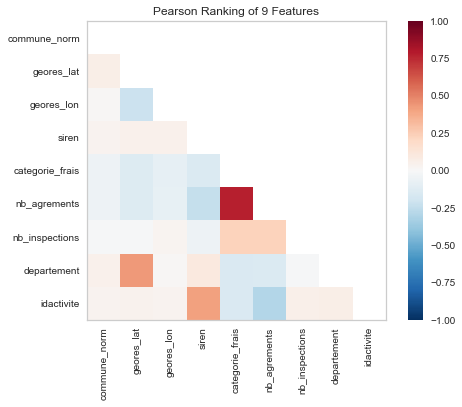

<AxesSubplot:title={'center':'Pearson Ranking of 9 Features'}>

In [7]:
from yellowbrick.features import Rank2D

r2D = Rank2D(algorithm='pearson')
r2D.fit(X)
r2D.transform(X)
r2D.show()

In [8]:
# print(np.corrcoef(X, rowvar=False))

# sns.pairplot(X)

In [9]:
# sns.pairplot(X[['geores_lat', 'geores_lon']])


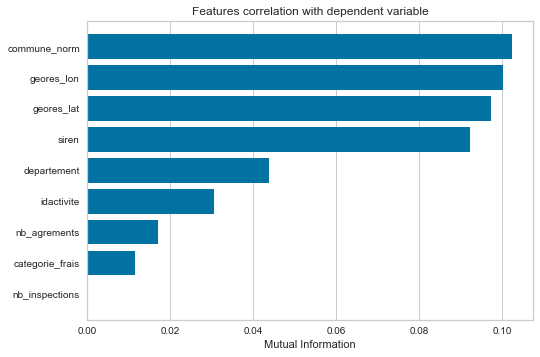

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [10]:
from yellowbrick.target import FeatureCorrelation
fc = FeatureCorrelation(method='mutual_info-regression', sort=True)
fc.fit(X, y, discrete_features=False)
fc.show()

In [11]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=0.7, random_state=42)

In [12]:
# print(yTrain.value_counts(normalize=True))
# print(yTest.value_counts(normalize=True))


In [13]:
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()

In [14]:
ZTrain = stdSc.fit_transform(XTrain)
ZTest = stdSc.transform(XTest)

In [15]:
# from sklearn.linear_model import LogisticRegression
# reg = LogisticRegression(solver='liblinear')

# from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
# reg=RandomForestClassifier(n_estimators=1000)

# from sklearn.ensemble import GradientBoostingClassifier
# reg = GradientBoostingClassifier()

from xgboost import XGBClassifier

reg = XGBClassifier(
    learning_rate =0.01,
    n_estimators=10000,
    max_depth=30,
    gamma=0,
    reg_alpha=0.005,
    objective= 'reg:linear',
    nthread=4,
    scale_pos_weight=99,
    seed=27,
    verbosity=0,
    max_cat_to_onehot=50,
    validate_parameters=False
    )

reg.fit(ZTrain, yTrain)

yPred = reg.predict(ZTest)

C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
from yellowbrick.model_selection import FeatureImportances
clfFI = FeatureImportances(reg, relative=False, labels=XTrain.columns)
clfFI.fit(ZTrain, yTrain)
clfFI.show()

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
clfConfusion = ConfusionMatrix(reg)
clfConfusion.score(ZTest, yTest)
clfConfusion.show()

In [ ]:
# from yellowbrick.classifier import DiscriminationThreshold
# clfDT = DiscriminationThreshold(reg, argmax='fscore')
# clfDT.fit(ZTrain, yTrain)
# clfDT.show()

In [ ]:
reg.score(ZTrain, yTrain)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(yTest, yPred))

In [ ]:
from joblib import dump,load

dump(reg,'jean_model.data')
# dump(reg,'arthur_model.data')
# dump(reg,'aissa_model.data')
